<a href="https://colab.research.google.com/github/beyondbond/eSTAR/blob/master/stock_analysis_with_deep_learning_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# stock_analysis_with_deep_learning_rnn
Stock predictions via TF RNN-LSTM like ARIMA -- AR(3) 


## 1. Import packages and define utility functions

In [0]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import datetime
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import os

def __del__(self):
	# cleanly ignore all exceptions
	try:
		self.close()
	except Exception: # pylint: disable=broad-except
		pass
	if self._session is not None:
		try:
			status = tf_session.TF_NewStatus()
			tf_session.TF_DeleteDeprecatedSession(self._session, status)
		finally:
			tf_session.TF_DeleteStatus(status)
		self._session = None

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=3,const_YN=0):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back):
                a = dataset[i:(i+look_back), 0]
                if const_YN==1:
                        a = np.append(a,1)
                dataX.append(a)
                dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)

# split into train and test sets
def train_test_split(data,look_back=3,const_YN=1, train_ratio=0.85):
        X_raw, y_raw = create_dataset(data,look_back,const_YN=const_YN)
        train_size = int(len(dataset) * train_ratio)
        test_size = len(dataset) - train_size
        X_train, X_test = X_raw[0:train_size], X_raw[train_size:]
        y_train, y_test = y_raw[0:train_size], y_raw[train_size:]
        return (X_train, y_train), (X_test, y_test)


Using TensorFlow backend.


## 2. Load Data

In [0]:
os.environ['TZ']='America/New_York'
params={"nb_epoch": 60, "batch_size": 18, "look_back": 3, "train_ratio": 0.8, "dropout_keep_prob": 0.1 ,"const_YN":1}
for ky,va in params.items():
        exec("{}=va".format(ky))

# fix random seed for reproducibility
np.random.seed(7)
# load the dataset
# df = pd.read_csv('spy.csv')
# load data from yahoo
ticker='SPY'
urx="https://query1.finance.yahoo.com/v8/finance/chart/{}?region=US&lang=en-US&includePrePost=false&interval={}&period2={}"
period2=datetime.datetime.today().date().strftime('%s')
url = urx.format(ticker,'1m',period2)
jTmp = pd.read_json(url)['chart']['result'][0]
pbdatetime = [ datetime.datetime.fromtimestamp(int(x)) for x in jTmp['timestamp'] ]
df=pd.DataFrame(jTmp['indicators']['quote'][0])
df['price']=df['close']
df['datetime']=pbdatetime
df.dropna(inplace=True)


## 3. Normalize the dataset

In [0]:
# normalize the dataset
dataset = df['price'].values
dataset = dataset.reshape(len(dataset),1)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

## 4. Split data into train and test sets

In [0]:
# split into train and test sets
(X_train,y_train),(X_test,y_test) = train_test_split(dataset,look_back,const_YN, train_ratio=train_ratio)
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [0]:
# Simplier model than in initial post
in_unit = X_train.shape[1]
out_unit = y_train.shape[-1]
hidden_unit = look_back+const_YN
print(X_train.shape,X_test.shape)

(240, 4, 1) (57, 4, 1)


## 4. Fitting RNN with LSTM

In [0]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=4, return_sequences=True, input_shape=(4, 1)))
model.add(LSTM(hidden_unit,return_sequences=False))
model.add(Dropout(dropout_keep_prob))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size, verbose=1, shuffle=False)


Epoch 1/60
240/240 [==============================] - 1s 3ms/step - loss: 0.2858
Epoch 2/60
240/240 [==============================] - 0s 182us/step - loss: 0.2486
Epoch 3/60
240/240 [==============================] - 0s 192us/step - loss: 0.2169
Epoch 4/60
240/240 [==============================] - 0s 187us/step - loss: 0.1773
Epoch 5/60
240/240 [==============================] - 0s 188us/step - loss: 0.1499
Epoch 6/60
240/240 [==============================] - 0s 196us/step - loss: 0.1195
Epoch 7/60
240/240 [==============================] - 0s 190us/step - loss: 0.0932
Epoch 8/60
240/240 [==============================] - 0s 187us/step - loss: 0.0739
Epoch 9/60
240/240 [==============================] - 0s 198us/step - loss: 0.0673
Epoch 10/60
240/240 [==============================] - 0s 189us/step - loss: 0.0545
Epoch 11/60
240/240 [==============================] - 0s 188us/step - loss: 0.0468
Epoch 12/60
240/240 [==============================] - 0s 189us/step - loss: 0.0409
Epo

## 5. Making the predictions

In [0]:
# make predictions
pred_train = model.predict(X_train, batch_size=batch_size)
model.reset_states()
pred_test = model.predict(X_test, batch_size=batch_size)
# invert predictions
pred_train = scaler.inverse_transform(pred_train)
pred_y = scaler.inverse_transform([y_train])
pred_test = scaler.inverse_transform(pred_test)
act_test = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(pred_y[0], pred_train[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(act_test[0], pred_test[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 0.09 RMSE
Test Score: 0.05 RMSE


## 6. Plotting the baseline and predictions

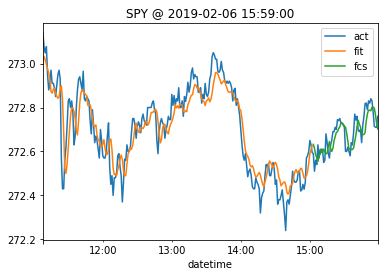

In [0]:
# plot baseline and predictions
pred_data=np.append(pred_train,pred_test)
ntrain=len(pred_train)
nobs=len(pred_data)
act_data=scaler.inverse_transform(dataset)[-nobs:]
actFitFcs=pd.DataFrame(np.column_stack([act_data,pred_data]),columns=['act','fit'])
actFitFcs['fcs']=actFitFcs['fit']
actFitFcs['fit'].iloc[ntrain:]=np.nan
actFitFcs['fcs'].iloc[:ntrain]=np.nan
#idxtm=map(lambda x:datetime.datetime.strptime(str(x),"%Y%m%d"),df['pbdate'].iloc[-nobs:])
idxtm=df['datetime'].iloc[-nobs:]
actFitFcs.set_index(pd.DatetimeIndex(idxtm),inplace=True)
title='{} @ {}'.format(ticker,idxtm.iloc[-1])
actFitFcs.iloc[-nobs+5:].plot(title=title)
plt.show()
